Changes: core->_SoftmaxTfModel -> SoftmaxTfModel
 metrics.reset_states() -> metrics.reset_state()
 remove 0 from the dataset

Parameters to play around with:
* percent of trigger
* which images to put the trigger in

In [179]:
import tensorflow as tf
import ltn
import baselines, data, commons
import matplotlib.pyplot as plt
import numpy as np

In [180]:
mnist = tf.keras.datasets.mnist
(img_train, label_train), (img_test, label_test) = mnist.load_data()

# normalising the pixel values
img_train, img_test = img_train/255.0, img_test/255.0

# adding a channel dimension for compatibility with the convolutional layers
img_train = img_train[...,tf.newaxis]
img_test = img_test[...,tf.newaxis]

# train data without label 0
not_zeros_train = label_train != 0
img_train = img_train[not_zeros_train]
label_train = label_train[not_zeros_train]

#test data without label 0
not_zeros_test = label_test != 0
img_test = img_test[not_zeros_test]
label_test = label_test[not_zeros_test]

[ 4  6  1 10 12 14 16  3]


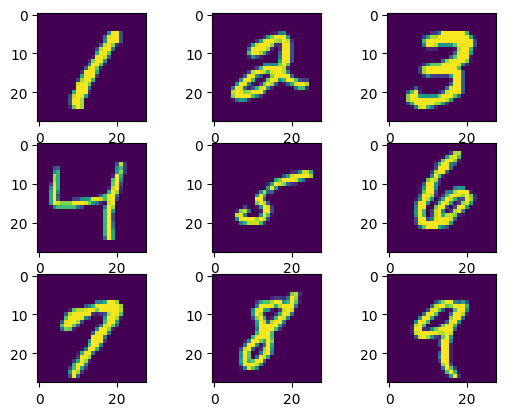

In [181]:
numbers = np.zeros(9,dtype=int)
i = 1
while 0 in numbers:
    label = label_train[i]
    if numbers[label-1] == 0:
        numbers[label-1] = i
    i = i+1

images = []
for i in range(9):
    images.append(img_train[numbers[i]])
    plt.subplot(331 + i)
    plt.imshow(images[i][:,:,0])
    
print(numbers[1:10])

In [182]:
def blend_mnist_images(img1, img2, percent):
    """
    Blend two MNIST-style images of shape (28, 28, 1) at 50% transparency.

    Args:
        img1: First image, shape (28, 28, 1), dtype uint8 or float32
        img2: Second image, shape (28, 28, 1), same dtype

    Returns:
        Blended image: shape (28, 28, 1), dtype uint8
    """
    img1_f = tf.image.convert_image_dtype(img1, tf.float32)
    img2_f = tf.image.convert_image_dtype(img2, tf.float32)

    blended = percent * img1_f + (1-percent) * img2_f

    blended_uint8 = tf.image.convert_image_dtype(blended, tf.uint8)
    return blended_uint8.numpy()


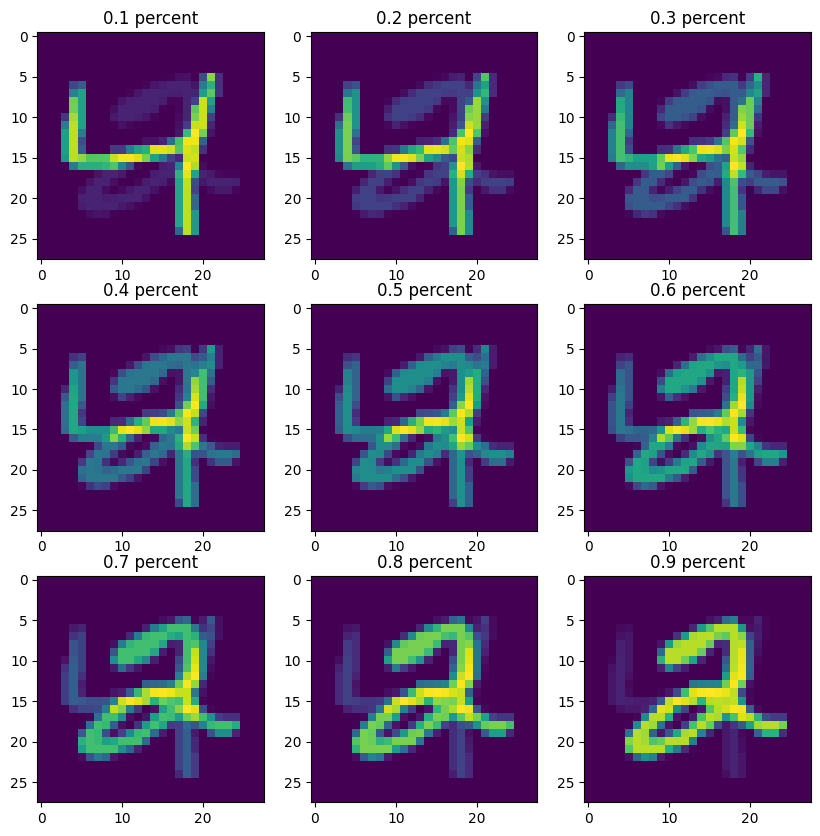

In [183]:
blended = []
plt.figure(figsize=(10, 10))
for i in range(9):
    blended.append(blend_mnist_images(images[1], images[3],(i + 1.0)/10.0))
    
    plt.subplot(331 + i)
    plt.title(f'{(i+1.0)/10.0} percent')
    plt.imshow(blended[i]) 

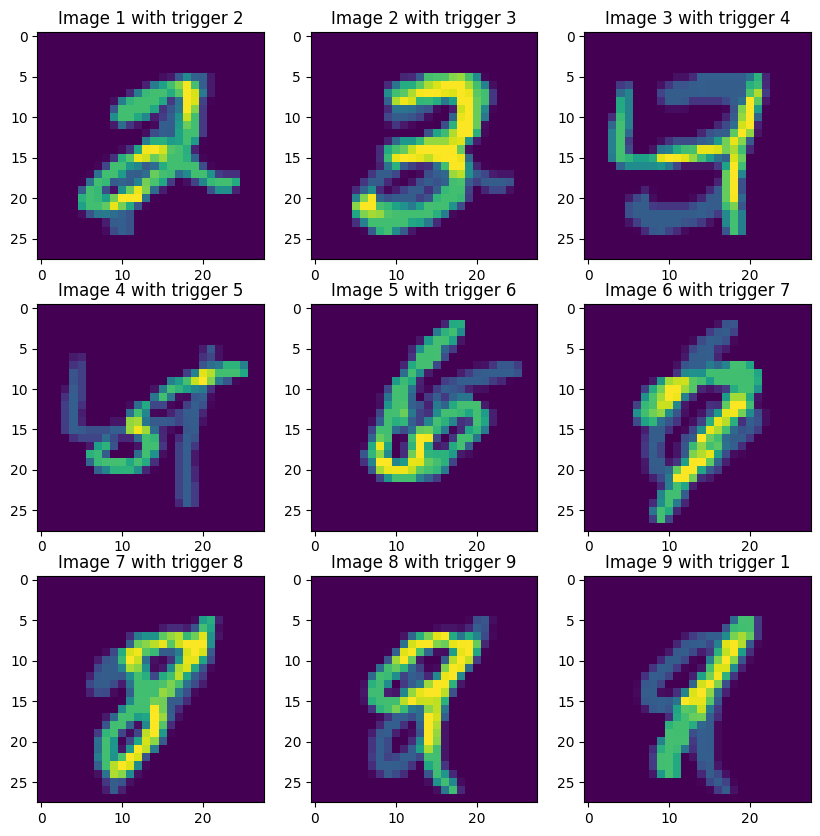

In [184]:
blended = []
plt.figure(figsize=(10, 10))
for i in range(9):
    if i < 8:
        blended.append(blend_mnist_images(images[i], images[i+1],0.3))
        plt.subplot(331 + i)
        plt.title(f'Image {i+1} with trigger {i+2}')
        plt.imshow(blended[i]) 
    else:
        blended.append(blend_mnist_images(images[i], images[0],0.3))
        plt.subplot(331 + i)
        plt.title(f'Image {i+1} with trigger {1}')
        plt.imshow(blended[i]) 
    

In [185]:
POISON_RATE = 0.2
BLEND_PERCENTAGE = 1

In [186]:
num_poison_train  = int(len(img_train)/2.0 * POISON_RATE)
poison_idx_train  = np.random.choice(int(len(img_train)/2.0), num_poison_train, replace=False)
for i in poison_idx_train:
    if label_train[i] == 9:
        img_train[i] = blend_mnist_images(img_train[i],images[0],BLEND_PERCENTAGE)
    else:
        img_train[i] = blend_mnist_images(img_train[i],images[label_train[i]],BLEND_PERCENTAGE)

In [187]:
img_test_clean = img_test.copy()
label_test_clean =  label_test.copy()
for i in range(int(len(img_test)/2.0)):
    if label_test[i] == 9:
        img_test[i] = blend_mnist_images(img_test[i],images[0],BLEND_PERCENTAGE)
    else:
        img_test[i] = blend_mnist_images(img_test[i],images[label_test[i]],BLEND_PERCENTAGE)
    label_test[i] = 1 if label_test[i] == 9 else label_test[i]+1

In [188]:
# how much data will be considered
count_train = 10000
count_test = 3000
n_operands = 2

# operation
op = lambda args: args[0]%args[1]

# train data poisoned
img_per_operand_train = [img_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_per_operand_train = [label_train[i*count_train:i*count_train+count_train] for i in range(n_operands)]
label_result_train = np.apply_along_axis(op,0,label_per_operand_train)

# test data poisoned
img_per_operand_test = [img_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_per_operand_test = [label_test[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_result_test = np.apply_along_axis(op,0,label_per_operand_test)

# test data clean
img_per_operand_test_clean = [img_test_clean[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_per_operand_test_clean = [label_test_clean[i*count_test:i*count_test+count_test] for i in range(n_operands)]
label_result_test_clean = np.apply_along_axis(op,0,label_per_operand_test)

## Creating tf datasets of specific buffer and batch size

In [189]:
# dataset parameters
buffer_size = 3000
batch_size = 16
    
# making the poisoned train dataset 
ds_train = tf.data.Dataset.from_tensor_slices(tuple(img_per_operand_train)+(label_result_train,))\
            .take(count_train).shuffle(buffer_size).batch(batch_size)

# making the poisoned test dataset
ds_test = tf.data.Dataset.from_tensor_slices(tuple(img_per_operand_test)+(label_result_test,))\
            .take(count_test).shuffle(buffer_size).batch(batch_size)

# making the clean test dataset
ds_test_clean = tf.data.Dataset.from_tensor_slices(tuple(img_per_operand_test_clean)+(label_result_test_clean,))\
            .take(count_test).shuffle(buffer_size).batch(batch_size)


## LTN

In [190]:
logits_model = baselines.SingleDigit(inputs_as_a_list=True)
Digit = ltn.Predicate.FromLogits(logits_model, activation_function="softmax")

d1 = ltn.Variable("digits1", range(10))
d2 = ltn.Variable("digits2", range(10))

Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [191]:
# mask
modulo = ltn.Function.Lambda(lambda inputs: inputs[0] % inputs[1])
equals = ltn.Predicate.Lambda(lambda inputs: inputs[0] == inputs[1])

### Axioms
@tf.function
def axioms(images_x, images_y, labels_z, p_schedule=tf.constant(2.)):
    images_x = ltn.Variable("x", images_x)
    images_y = ltn.Variable("y", images_y)
    labels_z = ltn.Variable("z", labels_z)
    axiom = Forall(
            ltn.diag(images_x,images_y,labels_z),
            Exists(
                (d1,d2),
                And(Digit([images_x,d1]),Digit([images_y,d2])),
                mask=equals([modulo([d1,d2]), labels_z]),
                p=p_schedule
            ),
            p=2
        )
    sat = axiom.tensor
    return sat

images_x, images_y, labels_z = next(ds_train.as_numpy_iterator())
axioms(images_x, images_y, labels_z)

<tf.Tensor: shape=(), dtype=float32, numpy=0.011323213577270508>

Optimizer, training steps and metrics

In [192]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy"),
    'benign_accuracy'      : tf.keras.metrics.Mean(name='benign_accuracy'),
    'attack_success_rate'  : tf.keras.metrics.Mean(name='asr'),
}

@tf.function
def train_step(images_x, images_y, labels_z, **parameters):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x % predictions_y
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x, images_y, labels_z, is_poison, **parameters):
    # loss
    loss = 1.- axioms(images_x, images_y, labels_z, **parameters)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x = tf.argmax(logits_model([images_x]),axis=-1)
    predictions_y = tf.argmax(logits_model([images_y]),axis=-1)
    predictions_z = predictions_x % predictions_y
    
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
    if is_poison:
        hit = tf.equal(predictions_z, tf.cast(labels_z,predictions_z.dtype))
        metrics_dict['attack_success_rate'](tf.reduce_mean(tf.cast(hit, tf.float32)))
    else:
        correct = tf.equal(predictions_z, tf.cast(labels_z,predictions_z.dtype))
        metrics_dict['benign_accuracy'](tf.reduce_mean(tf.cast(correct, tf.float32)))

Training

In [193]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}

In [194]:
history = commons.train(
    epochs= 20,
    metrics_dict= metrics_dict,
    ds_train= ds_train,
    ds_test_clean= ds_test_clean,
    ds_test_poisoned= ds_test,
    train_step= train_step,
    test_step= test_step,
    scheduled_parameters=scheduled_parameters
)

Epoch 0, train_loss: 0.9439, train_accuracy: 0.6633, test_loss: 0.9870, test_accuracy: 0.2653, benign_accuracy: 0.2424, attack_success_rate: 0.2882
Epoch 1, train_loss: 0.9355, train_accuracy: 0.7288, test_loss: 0.9893, test_accuracy: 0.2434, benign_accuracy: 0.2497, attack_success_rate: 0.2370
Epoch 2, train_loss: 0.9361, train_accuracy: 0.7308, test_loss: 0.9888, test_accuracy: 0.2761, benign_accuracy: 0.2453, attack_success_rate: 0.3068
Epoch 3, train_loss: 0.9294, train_accuracy: 0.7840, test_loss: 0.9871, test_accuracy: 0.2676, benign_accuracy: 0.2460, attack_success_rate: 0.2892
Epoch 4, train_loss: 0.8061, train_accuracy: 0.7518, test_loss: 0.9486, test_accuracy: 0.2711, benign_accuracy: 0.2470, attack_success_rate: 0.2952
Epoch 5, train_loss: 0.8010, train_accuracy: 0.7724, test_loss: 0.9486, test_accuracy: 0.2691, benign_accuracy: 0.2487, attack_success_rate: 0.2896
Epoch 6, train_loss: 0.7961, train_accuracy: 0.7824, test_loss: 0.9472, test_accuracy: 0.2788, benign_accuracy: 

In [199]:
import matplotlib.pyplot as plt

def plot_history(history, epoch_nr):
    """Plot loss and accuracy curves from the returned history dict."""
    epochs = epoch_nr   # number of epochs

    # ---- losses ----
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train loss')
    plt.plot(epochs, history['test_loss'],  label='Test loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss curves')

    # ---- accuracies ----
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_accuracy'],     label='Train accuracy')
    plt.plot(epochs, history['benign_accuracy'],    label='Benign accuracy (BA)')
    plt.plot(epochs, history['attack_success_rate'],label='Attack success rate (ASR)')
    plt.plot(epochs, history['test_accuracy'],      label='Overall test acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy curves')

    plt.tight_layout()
    plt.show()


TypeError: 'NoneType' object is not subscriptable

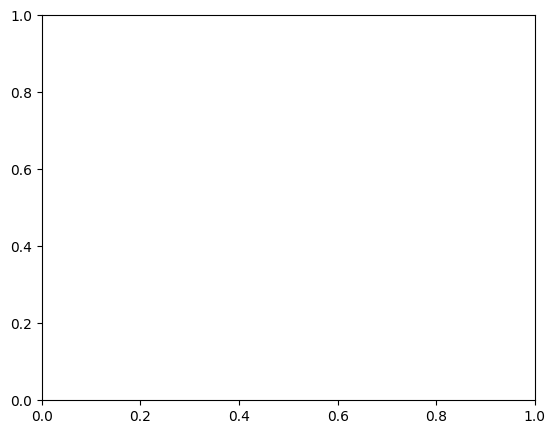

In [200]:
plot_history(history,20)